**Multi Run Plans**

In this notebook we will look at running, and plotting from plans run repeatedly. 


In [19]:
# 1. Running sequential plans

#configure a temp run engine environment

from bluesky import RunEngine

RE = RunEngine({})

from bluesky.callbacks.best_effort import BestEffortCallback
bec = BestEffortCallback()

# Send all metadata/data captured to the BestEffortCallback.
RE.subscribe(bec)

#Get the databroker https://gist.github.com/untzag/53281819709b1058c7708a250cbd3676
from databroker.v2 import temp
db = temp()

# Insert all metadata/data captured into db.
RE.subscribe(db.v1.insert)


1

In [ ]:
#Lets define a simulated detector https://github.com/bluesky/ophyd/blob/7937cd46e92e9ec2f7eec321dd5b1b1b71115e20/ophyd/sim.py#L475
from ophyd.sim import det, motor
from ophyd.sim import motor1,motor2, Syn2DGauss, SynGauss
from bluesky.plans import scan, adaptive_scan, grid_scan
import numpy as np
s = np.random.RandomState(0)


# And we will make it noisy
my_det = SynGauss('my_det', motor, 'motor', center=0, Imax=1, sigma=1,noise_multiplier=0.1)
my_det.noise.set('uniform')

# Now we can perform a scan and see the result

RE(scan([my_det],motor, -1,1,10))



Transient Scan ID: 1     Time: 2021-08-31 12:07:26
Persistent Unique Scan ID: '77d1e2a2-3df6-4d3e-b371-51ec5fac6af7'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |      motor |     my_det |
+-----------+------------+------------+------------+
|         1 | 12:07:26.4 |     -1.000 |      0.653 |
|         2 | 12:07:26.4 |     -0.778 |      0.789 |
|         3 | 12:07:26.5 |     -0.556 |      0.866 |




Transient Scan ID: 14     Time: 2021-08-31 12:05:45
Persistent Unique Scan ID: 'd07f1bc2-4a47-4e5c-a0f7-aa9643c50097'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |      motor |     my_det |
+-----------+------------+------------+------------+
|         1 | 12:05:45.2 |     -1.000 |      0.579 |
|         2 | 12:05:45.2 |     -0.778 |      0.755 |
|         3 | 12:05:45.3 |     -0.556 |      0.791 |
|         4 | 12:05:45.3 |     -0.333 |      0.908 |
|         5 | 12:05:45.4 |     -0.111 |      1.013 |
|         6 | 12:05:45.4 |      0.111 |      0.932 |
|         7 | 12:05:45.4 |      0.333 |      0.962 |
|         8 | 12:05:45.5 |      0.556 |      0.797 |
|         9 | 12:05:45.5 |      0.778 |      0.665 |
|        10 | 12:05:45.5 |      1.000 |      0.624 |
+-----------+------------+------------+------------+
generator scan ['d07f1bc2'] (scan num: 14)





Transient Scan ID: 15     Time: 2021-08-31 12:05:45
Persistent Uniqu

('d07f1bc2-4a47-4e5c-a0f7-aa9643c50097',
 '77fcc14f-b8a5-49f6-8e47-278622d5b9e7',
 '9f77a525-dea3-4d91-a533-4fda820270ce',
 'b981a28c-bd24-4c68-9c9c-2926623c9c2d',
 '59b87d5a-6061-47cc-aeef-04864071ea1a',
 '6bf9c51b-ee77-48d3-b1e6-331650e1078c',
 'd6395946-2783-4403-87dc-632f3ff10065',
 '865b298a-c4c2-45f9-9633-6c8e62e90c54',
 '917c91cf-3a4e-4377-8eb5-214f4e002a04',
 'a32fcc38-1e6d-464f-bb9e-565cc0f3cf5c')

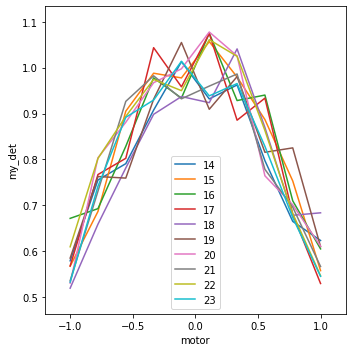

In [10]:
# https://nsls-ii.github.io/bluesky/multi_run_plans.html#plans-with-sequential-runs

def plan_sequential_runs(detectors, *args, num=None, num_runs=None, per_step=None, md=None):
    # Single-run plans may be called consecutively. No special handling is required
    #   as long as the previous scan is closed before the next one is opened
    
    for x in range(num_runs):
        yield from scan(detectors, *args, num=None, per_step=None, md=None)



RE(plan_sequential_runs([my_det],motor, -1,1,10,num_runs=10),reason="Multi Run Plan")

In [12]:
# Now lets plot offline the summation of these runs


results = db.search({"plan_name":"scan","motors":"motor","reason":"Multi Run Plan","plan_pattern_args.num":10 })
print(len(results)

SyntaxError: unexpected EOF while parsing (<ipython-input-12-672ad7d7d012>, line 5)

Text(0, 0.5, 'my_det')

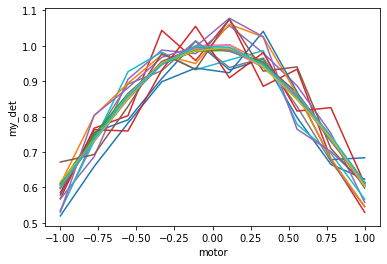

In [13]:
 import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for uid, run in results.items():
    data = run.primary.read()
    ax.plot(data.motor, data.my_det) # Note that this looses lots of the context given in the xarray
    
    
plt.xlabel('motor')
plt.ylabel(run.primary.metadata['start']['detectors'][0])

In [14]:
# Now we will make the sum of them
import numpy as np

import xarray as xr

print(run.primary.metadata['start']['plan_pattern_args']['num'])
det_sum = xr.DataArray(np.zeros(run.primary.metadata['start']['plan_pattern_args']['num']))
print(np.asarray(det_sum))

10
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


<xarray.DataArray (dim_0: 10)>
array([11.75887135, 14.77294741, 17.02083159, 19.09836007, 19.69174764,
       19.93406408, 19.23239148, 17.04881059, 14.45731636, 11.95923618])
Dimensions without coordinates: dim_0


Text(0, 0.5, 'my_det')

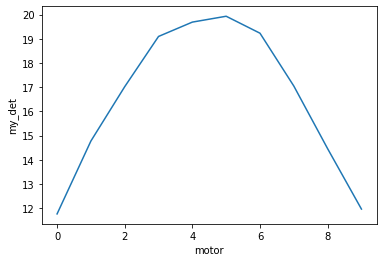

In [15]:

fig, ax = plt.subplots()
for uid, run in results.items():
    data = run.primary.read()
    det_sum = np.add(det_sum,np.asarray(data.my_det.values))

print(det_sum)


ax.plot(det_sum) # Note that this looses lots of the context given in the xarray
    
    
plt.xlabel('motor')
plt.ylabel(run.primary.metadata['start']['detectors'][0])


